**Author:** Raoul Malm  

**Description:** 

This notebook demonstrates the future price prediction for different stocks using recurrent neural networks in tensorflow. Recurrent neural networks with basic, LSTM or GRU cells are implemented. 

**Outline:**

1. [Libraries and settings](#1-bullet)
2. [Analyze data](#2-bullet)
3. [Manipulate data](#3-bullet)
4. [Model and validate data](#4-bullet)
5. [Predictions](#5-bullet)

**Reference:**  

[LSTM_Stock_prediction-20170507 by BenF](https://www.kaggle.com/benjibb/lstm-stock-prediction-20170507/notebook)

# 1. Libraries and settings <a class="anchor" id="1-bullet"></a> 

In [17]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
# import tensorflow as tf

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.disable_eager_execution()

# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

#display parent directory and working directory
print(os.path.dirname(os.getcwd())+':', os.listdir(os.path.dirname(os.getcwd())));
print(os.getcwd()+':', os.listdir(os.getcwd()));

Instructions for updating:
non-resource variables are not supported in the long term
/Users/wyx/projects/priceprediction: ['.DS_Store', 'input', 'README.md', '.gitignore', '.ipynb_checkpoints', 'notebook', '.git']
/Users/wyx/projects/priceprediction/notebook: ['ny-stock-price-prediction-rnn-lstm-gru.ipynb', '.ipynb_checkpoints']


# 2. Analyze data <a class="anchor" id="2-bullet"></a> 
- load stock prices from prices-split-adjusted.csv
- analyze data

In [2]:
# import all stock prices 
df = pd.read_csv("../input/prices-split-adjusted.csv", index_col = 0)
df.info()
df.head()

# number of different stocks
print('\nnumber of different stocks: ', len(list(set(df.symbol))))
print(list(set(df.symbol))[:10])

<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  851264 non-null  object 
 1   open    851264 non-null  float64
 2   close   851264 non-null  float64
 3   low     851264 non-null  float64
 4   high    851264 non-null  float64
 5   volume  851264 non-null  float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB

number of different stocks:  501
['LVLT', 'LLTC', 'URBN', 'WFM', 'EIX', 'AN', 'CMCSA', 'CF', 'IPG', 'BAC']


In [3]:
df.tail()

,symbol,open,close,low,high,volume
date,,,,,,
2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0
2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0
2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0
2016-12-30,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0
2016-12-30,FTV,54.200001,53.630001,53.389999,54.480000,705100.0


In [4]:
df.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  851264 non-null  object 
 1   open    851264 non-null  float64
 2   close   851264 non-null  float64
 3   low     851264 non-null  float64
 4   high    851264 non-null  float64
 5   volume  851264 non-null  float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB


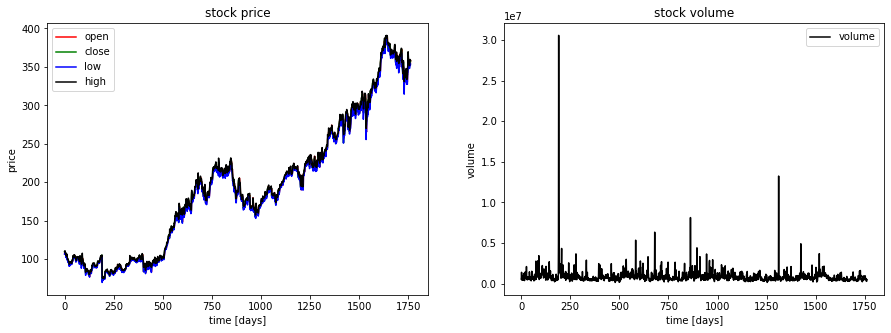

In [6]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df[df.symbol == 'EQIX'].open.values, color='red', label='open')
plt.plot(df[df.symbol == 'EQIX'].close.values, color='green', label='close')
plt.plot(df[df.symbol == 'EQIX'].low.values, color='blue', label='low')
plt.plot(df[df.symbol == 'EQIX'].high.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(df[df.symbol == 'EQIX'].volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

# 3. Manipulate data <a class="anchor" id="3-bullet"></a> 
- choose a specific stock
- drop feature: volume
- normalize stock data
- create train, validation and test data sets

In [9]:
# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    # data_raw = stock.as_matrix() # convert to numpy array
    data_raw = stock.values
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# choose one stock
df_stock = df[df.symbol == 'EQIX'].copy()
df_stock.drop(['symbol'],1,inplace=True)
df_stock.drop(['volume'],1,inplace=True)

cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols)

# normalize stock
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

df_stock.columns.values =  ['open', 'close', 'low', 'high']
x_train.shape =  (1394, 19, 4)
y_train.shape =  (1394, 4)
x_valid.shape =  (174, 19, 4)
y_valid.shape =  (174, 4)
x_test.shape =  (174, 19, 4)
y_test.shape =  (174, 4)


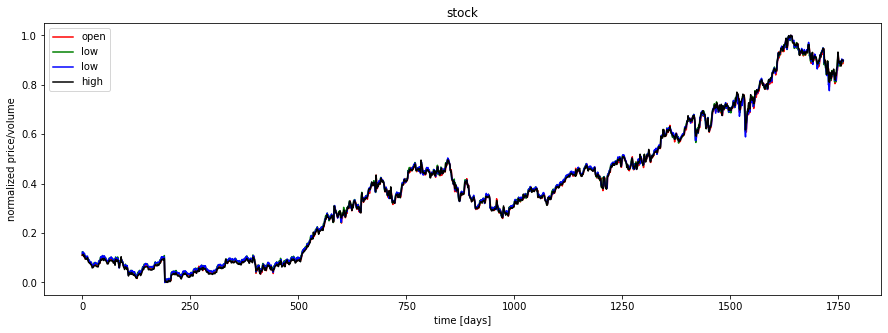

In [10]:
plt.figure(figsize=(15, 5));
plt.plot(df_stock_norm.open.values, color='red', label='open')
plt.plot(df_stock_norm.close.values, color='green', label='low')
plt.plot(df_stock_norm.low.values, color='blue', label='low')
plt.plot(df_stock_norm.high.values, color='black', label='high')
#plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()

In [31]:
df[df.symbol == 'EQIX'].shape

(1762, 6)

In [36]:
x_train.shape, x_valid.shape, x_test.shape

((1394, 19, 4), (174, 19, 4), (174, 19, 4))

In [57]:
df_stock_norm[:21]

,open,close,low,high
date,,,,
2010-01-04,0.109250,0.122904,0.117440,0.110911
2010-01-05,0.118896,0.119708,0.123361,0.110816
2010-01-06,0.116886,0.122810,0.122855,0.113912
2010-01-07,0.117828,0.115791,0.117852,0.113217
2010-01-08,0.110130,0.114161,0.115509,0.103519
2010-01-11,0.110664,0.116919,0.118042,0.106267
2010-01-12,0.109502,0.103256,0.106200,0.104688
2010-01-13,0.095834,0.102598,0.103952,0.094295
2010-01-14,0.099196,0.105857,0.107340,0.095590


In [44]:
sum(map(lambda x: x[0], [x_train.shape, x_valid.shape, x_test.shape]))

1742

In [55]:
x_train[:2]

array([[[0.10925029, 0.12290433, 0.11744033, 0.11091105],
        [0.11889648, 0.11970795, 0.12336141, 0.11081625],
        [0.11688555, 0.12281032, 0.1228548 , 0.11391205],
        [0.11782819, 0.1157908 , 0.11785195, 0.11321707],
        [0.11013009, 0.11416126, 0.11550885, 0.10351907],
        [0.11066424, 0.11691894, 0.11804192, 0.10626737],
        [0.10950166, 0.10325594, 0.10619974, 0.10468789],
        [0.09583359, 0.10259786, 0.10395163, 0.09429492],
        [0.09919562, 0.10585693, 0.10733963, 0.09559008],
        [0.10252622, 0.09955816, 0.10173518, 0.094674  ],
        [0.09721612, 0.10526152, 0.10189349, 0.09366313],
        [0.09771884, 0.10375732, 0.10306505, 0.09325245],
        [0.09878716, 0.10350664, 0.10670637, 0.10029694],
        [0.09881856, 0.08987496, 0.09261605, 0.09397902],
        [0.08800981, 0.09322804, 0.09397758, 0.0839967 ],
        [0.08687866, 0.0912538 , 0.09293268, 0.08112206],
        [0.08530761, 0.09059573, 0.08992465, 0.0791951 ],
        [0.086

In [56]:
y_train[:2]

array([[0.07836361, 0.07994109, 0.08194543, 0.07363532],
       [0.07591279, 0.08222871, 0.07998228, 0.07180312]])

# 4. Model and validate data <a class="anchor" id="4-bullet"></a> 
- RNNs with basic, LSTM, GRU cells


In [167]:
## Basic Cell RNN in tensorflow

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

In [168]:
# use Basic RNN Cell
# layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
#           for layer in range(n_layers)]

layers = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]

# use Basic LSTM Cell 
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# use GRU cell
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]

In [169]:
# multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)

In [170]:
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    mse_train = loss.eval(feed_dict={X: x_train, y: y_train})
    mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid})
    print('0 epochs, 0 iterations: MSE train/valid = %.6f/%.6f'
          % (mse_train, mse_valid))
    
    for iteration in range(1, math.floor(n_epochs * train_set_size / batch_size) + 1):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch})
        
        if iteration % math.floor(5 * train_set_size / batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train})
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid})
            print('%d epochs, %d iterations: MSE train/valid = %.6f/%.6f'
                  % (math.ceil(iteration * batch_size / train_set_size), 
                     iteration, 
                     mse_train, 
                     mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})

0 epochs, 0 iterations: MSE train/valid = 0.058611 / 0.322857
5 epochs, 139 iterations: MSE train/valid = 0.000201 / 0.001500
10 epochs, 278 iterations: MSE train/valid = 0.000179 / 0.000831
15 epochs, 417 iterations: MSE train/valid = 0.000156 / 0.000988
20 epochs, 556 iterations: MSE train/valid = 0.000124 / 0.000640
25 epochs, 695 iterations: MSE train/valid = 0.000110 / 0.000372
30 epochs, 834 iterations: MSE train/valid = 0.000098 / 0.000378
35 epochs, 973 iterations: MSE train/valid = 0.000089 / 0.000326
40 epochs, 1112 iterations: MSE train/valid = 0.000085 / 0.000259
45 epochs, 1251 iterations: MSE train/valid = 0.000097 / 0.000262
50 epochs, 1390 iterations: MSE train/valid = 0.000073 / 0.000279
55 epochs, 1529 iterations: MSE train/valid = 0.000089 / 0.000276
60 epochs, 1668 iterations: MSE train/valid = 0.000073 / 0.000264
65 epochs, 1807 iterations: MSE train/valid = 0.000072 / 0.000275
70 epochs, 1946 iterations: MSE train/valid = 0.000067 / 0.000248
75 epochs, 2085 iterat

In [180]:
x_batch.shape

(50, 19, 4)

# 5. Predictions <a class="anchor" id="5-bullet"></a> 

correct sign prediction for close - open price for train/valid/test: 0.75/0.61/0.60


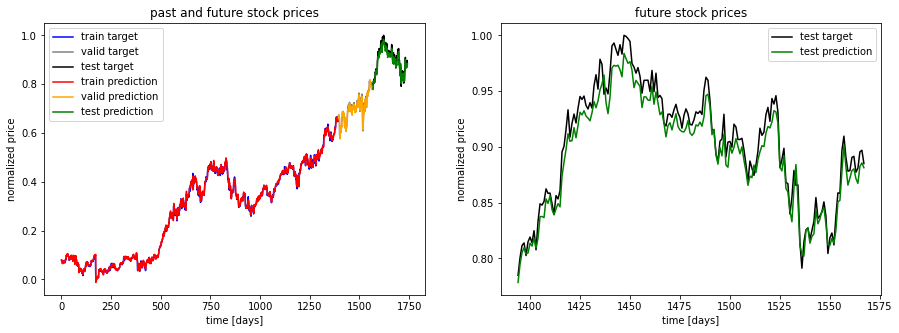

In [175]:
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('past and future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'
      % (corr_price_development_train, 
         corr_price_development_valid, 
         corr_price_development_test))